# Applying a few libraries and algorithms to the data set    
This notebook has been used to asses libraries and algorithms that can/maybe be used for capstone.    
Starting by using the metadata and cleaning the data frame.   

### Importing the libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import time
import warnings 
from pandas_profiling import ProfileReport
warnings.filterwarnings('ignore')

### Loading the data from the temp store

In [15]:
cord_metadata_raw = pd.read_csv('temp/alleninstitute_metadata.csv')
metadata = cord_metadata_raw.copy(deep=True)
metadata.columns

Index(['Unnamed: 0', 'cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid',
       'pubmed_id', 'license', 'abstract', 'publish_time', 'authors',
       'journal', 'microsoft academic paper id', 'who #covidence',
       'has_full_text', 'full_text_file', 'url'],
      dtype='object')

In [16]:
print(f'\nINFO\n{metadata.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161564 entries, 0 to 161563
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   161564 non-null  int64  
 1   cord_uid                     161564 non-null  object 
 2   sha                          72840 non-null   object 
 3   source_x                     161564 non-null  object 
 4   title                        161514 non-null  object 
 5   doi                          123564 non-null  object 
 6   pmcid                        78160 non-null   object 
 7   pubmed_id                    107809 non-null  float64
 8   license                      161564 non-null  object 
 9   abstract                     119002 non-null  object 
 10  publish_time                 161549 non-null  object 
 11  authors                      155737 non-null  object 
 12  journal                      152546 non-null  object 
 13 

### Counting unique words in title and abstract in order to later eliminate some outliers    

In [17]:
# Count of all tokens in the columns and unique words in the columns
metadata['abstract_word_count'] = metadata['abstract'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in abstract
metadata['abstract_unique_words']=metadata['abstract'].astype(str).apply(lambda x:len(set(str(x).split())))  # number of unique words in body
metadata['title_word_count'] = metadata['title'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in body
metadata['title_unique_count'] = metadata['title'].astype(str).apply(lambda x: len(x.strip().split()))  # word count in body

metadata.head()

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,Factors Associated With Surgical Mortality and...,NaN,NaN,NaN,unk,Importance: There are limited data on mortalit...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,COVID-19 outbreak in Northern Italy: Viewpoint...,NaN,NaN,NaN,unk,NaN,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,Keeping the country positive during the COVID ...,NaN,NaN,NaN,unk,NaN,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,An analysis of spatiotemporal pattern for COIV...,NaN,NaN,NaN,unk,This study seeks to examine and analyze the sp...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,Atypical Presentation of COVID-19 Incidentally...,NaN,NaN,NaN,unk,"The incidence of COVID-19, a severe acute resp...",...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14


### Eliminating some NULL values

In [18]:
# Check if NULL values are present in the dataset along with count of the NULL values
for col in metadata.columns:
    print(col, metadata[col].isnull().sum())

Unnamed: 0 0
cord_uid 0
sha 88724
source_x 0
title 50
doi 38000
pmcid 83404
pubmed_id 53755
license 0
abstract 42562
publish_time 15
authors 5827
journal 9018
microsoft academic paper id 161564
who #covidence 161564
has_full_text 161564
full_text_file 161564
url 25087
abstract_word_count 0
abstract_unique_words 0
title_word_count 0
title_unique_count 0


In [19]:
# Let’s delete all rows for whose word count is 0
metadata.drop(metadata.index[metadata['abstract_word_count'] == 0], inplace = True)
metadata.drop(metadata.index[metadata['title_word_count'] == 0], inplace = True)
metadata

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,Factors Associated With Surgical Mortality and...,NaN,NaN,NaN,unk,Importance: There are limited data on mortalit...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,COVID-19 outbreak in Northern Italy: Viewpoint...,NaN,NaN,NaN,unk,NaN,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,Keeping the country positive during the COVID ...,NaN,NaN,NaN,unk,NaN,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,An analysis of spatiotemporal pattern for COIV...,NaN,NaN,NaN,unk,This study seeks to examine and analyze the sp...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,Atypical Presentation of COVID-19 Incidentally...,NaN,NaN,NaN,unk,"The incidence of COVID-19, a severe acute resp...",...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161559,161559,vz7p89zq,NaN,WHO,Rapid establishment of laboratory diagnostics ...,NaN,NaN,NaN,unk,The need for timely establishment of diagnosti...,...,Euro surveill,NaN,NaN,NaN,NaN,NaN,75,61,15,15
161560,161560,hnbuyb1e,NaN,WHO,Myocardial injury in severe COVID-19 infection,NaN,NaN,NaN,unk,NaN,...,Eur Heart J,NaN,NaN,NaN,NaN,NaN,1,1,6,6
161561,161561,cf98ysl3,NaN,WHO,Cardiovascular disease and surgery amid COVID-...,NaN,NaN,NaN,unk,NaN,...,J. vasc. surg,NaN,NaN,NaN,NaN,NaN,1,1,7,7
161562,161562,hl27gjbo,NaN,ArXiv,Diffusion as a First Model of Spread of Viral ...,NaN,NaN,NaN,arxiv,The appearance of the coronavirus (COVID-19) i...,...,NaN,NaN,NaN,NaN,NaN,https://arxiv.org/pdf/2003.11449v2.pdf,139,88,10,10


### Converting strings to Lower case

In [20]:
metadata["abstract"] = metadata["abstract"].str.lower() 
metadata["title"] = metadata["title"].str.lower() 
metadata

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,factors associated with surgical mortality and...,NaN,NaN,NaN,unk,importance: there are limited data on mortalit...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,covid-19 outbreak in northern italy: viewpoint...,NaN,NaN,NaN,unk,NaN,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,keeping the country positive during the covid ...,NaN,NaN,NaN,unk,NaN,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,an analysis of spatiotemporal pattern for coiv...,NaN,NaN,NaN,unk,this study seeks to examine and analyze the sp...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,atypical presentation of covid-19 incidentally...,NaN,NaN,NaN,unk,"the incidence of covid-19, a severe acute resp...",...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161559,161559,vz7p89zq,NaN,WHO,rapid establishment of laboratory diagnostics ...,NaN,NaN,NaN,unk,the need for timely establishment of diagnosti...,...,Euro surveill,NaN,NaN,NaN,NaN,NaN,75,61,15,15
161560,161560,hnbuyb1e,NaN,WHO,myocardial injury in severe covid-19 infection,NaN,NaN,NaN,unk,NaN,...,Eur Heart J,NaN,NaN,NaN,NaN,NaN,1,1,6,6
161561,161561,cf98ysl3,NaN,WHO,cardiovascular disease and surgery amid covid-...,NaN,NaN,NaN,unk,NaN,...,J. vasc. surg,NaN,NaN,NaN,NaN,NaN,1,1,7,7
161562,161562,hl27gjbo,NaN,ArXiv,diffusion as a first model of spread of viral ...,NaN,NaN,NaN,arxiv,the appearance of the coronavirus (covid-19) i...,...,NaN,NaN,NaN,NaN,NaN,https://arxiv.org/pdf/2003.11449v2.pdf,139,88,10,10


### Removing the stop words

In [21]:
import nltk
nltk.download('stopwords')

stopwords_custom = nltk.corpus.stopwords.words('english')
customize_stop_words = ['common','review','describes','abstract','retrospective','chart','patients','study','may',
                        'associated','results','including','high''found','one','well','among','Abstract','provide',
                        'objective','objective:','background','range','features','participates','doi', 'preprint', 
                        'copyright', 'org', 'https', 'et ','et' 'al', 'author', 'figure', 'table', 'rights', 'reserved', 
                        'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 
                        'Elsevier', 'PMC', 'CZI']
### append custom stopwords to default stopwords from NLTK
for i in customize_stop_words:
    stopwords_custom.append(i)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dantohe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
metadata['abstract'] = metadata['abstract'].astype(str)
metadata['title'] = metadata['title'].astype(str)
metadata['abstract'] = metadata['abstract'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
metadata['title'] = metadata['title'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
metadata

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,factors surgical mortality complications witho...,NaN,NaN,NaN,unk,importance: limited data mortality complicatio...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,covid-19 outbreak northern italy: viewpoint mi...,NaN,NaN,NaN,unk,nan,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,keeping country positive covid 19 pandemic: ev...,NaN,NaN,NaN,unk,nan,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,analysis spatiotemporal pattern coivd-19 china...,NaN,NaN,NaN,unk,seeks examine analyze spatial temporal pattern...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,atypical presentation covid-19 incidentally de...,NaN,NaN,NaN,unk,"incidence covid-19, severe acute respiratory s...",...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161559,161559,vz7p89zq,NaN,WHO,rapid establishment laboratory diagnostics nov...,NaN,NaN,NaN,unk,need timely establishment diagnostic assays ar...,...,Euro surveill,NaN,NaN,NaN,NaN,NaN,75,61,15,15
161560,161560,hnbuyb1e,NaN,WHO,myocardial injury severe covid-19 infection,NaN,NaN,NaN,unk,nan,...,Eur Heart J,NaN,NaN,NaN,NaN,NaN,1,1,6,6
161561,161561,cf98ysl3,NaN,WHO,cardiovascular disease surgery amid covid-19 p...,NaN,NaN,NaN,unk,nan,...,J. vasc. surg,NaN,NaN,NaN,NaN,NaN,1,1,7,7
161562,161562,hl27gjbo,NaN,ArXiv,diffusion first model spread viral infection,NaN,NaN,NaN,arxiv,appearance coronavirus (covid-19) late 2019 do...,...,NaN,NaN,NaN,NaN,NaN,https://arxiv.org/pdf/2003.11449v2.pdf,139,88,10,10


### Removing the Contraction Words

In [23]:
!python3 -m pip install contractions

Defaulting to user installation because normal site-packages is not writeable


In [24]:
# Using contractions library for replacing the contracted words in English 
import contractions
metadata['abstract'] = metadata['abstract'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
metadata['title'] = metadata['title'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
metadata.head()

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,factors surgical mortality complications witho...,NaN,NaN,NaN,unk,importance: limited data mortality complicatio...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,covid-19 outbreak northern italy: viewpoint mi...,NaN,NaN,NaN,unk,nan,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,keeping country positive covid 19 pandemic: ev...,NaN,NaN,NaN,unk,nan,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,analysis spatiotemporal pattern coivd-19 china...,NaN,NaN,NaN,unk,seeks examine analyze spatial temporal pattern...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,atypical presentation covid-19 incidentally de...,NaN,NaN,NaN,unk,"incidence covid-19, severe acute respiratory s...",...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14


### Remove punctuation marks

In [25]:
from nltk.tokenize import RegexpTokenizer
tokenizer_pattern = RegexpTokenizer('\w+')
metadata['abstract'] = metadata['abstract'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
metadata['title'] = metadata['title'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
metadata

,Unnamed: 0,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,journal,microsoft academic paper id,who #covidence,has_full_text,full_text_file,url,abstract_word_count,abstract_unique_words,title_word_count,title_unique_count
0,0,lom1dbk7,NaN,WHO,factors surgical mortality complications witho...,NaN,NaN,NaN,unk,importance limited data mortality complication...,...,JAMA surg. (Online),NaN,NaN,NaN,NaN,NaN,401,234,18,18
1,1,f6pioe0x,NaN,WHO,covid 19 outbreak northern italy viewpoint mil...,NaN,NaN,NaN,unk,nan,...,J Trauma Acute Care Surg,NaN,NaN,NaN,NaN,NaN,1,1,12,12
2,2,pzkltzv2,NaN,WHO,keeping country positive covid 19 pandemic evi...,NaN,NaN,NaN,unk,nan,...,Asian J Psychiatr,NaN,NaN,NaN,NaN,NaN,1,1,12,12
3,3,ysogcprc,NaN,WHO,analysis spatiotemporal pattern coivd 19 china...,NaN,NaN,NaN,unk,seeks examine analyze spatial temporal pattern...,...,J. med. virol,NaN,NaN,NaN,NaN,NaN,218,135,13,13
4,4,wkbddypb,NaN,WHO,atypical presentation covid 19 incidentally de...,NaN,NaN,NaN,unk,incidence covid 19 severe acute respiratory sy...,...,Clin. nucl. med,NaN,NaN,NaN,NaN,NaN,99,74,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161559,161559,vz7p89zq,NaN,WHO,rapid establishment laboratory diagnostics nov...,NaN,NaN,NaN,unk,need timely establishment diagnostic assays ar...,...,Euro surveill,NaN,NaN,NaN,NaN,NaN,75,61,15,15
161560,161560,hnbuyb1e,NaN,WHO,myocardial injury severe covid 19 infection,NaN,NaN,NaN,unk,nan,...,Eur Heart J,NaN,NaN,NaN,NaN,NaN,1,1,6,6
161561,161561,cf98ysl3,NaN,WHO,cardiovascular disease surgery amid covid 19 p...,NaN,NaN,NaN,unk,nan,...,J. vasc. surg,NaN,NaN,NaN,NaN,NaN,1,1,7,7
161562,161562,hl27gjbo,NaN,ArXiv,diffusion first model spread viral infection,NaN,NaN,NaN,arxiv,appearance coronavirus covid 19 late 2019 domi...,...,NaN,NaN,NaN,NaN,NaN,https://arxiv.org/pdf/2003.11449v2.pdf,139,88,10,10


### Data Visualization

In [37]:
# Thanks to https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    

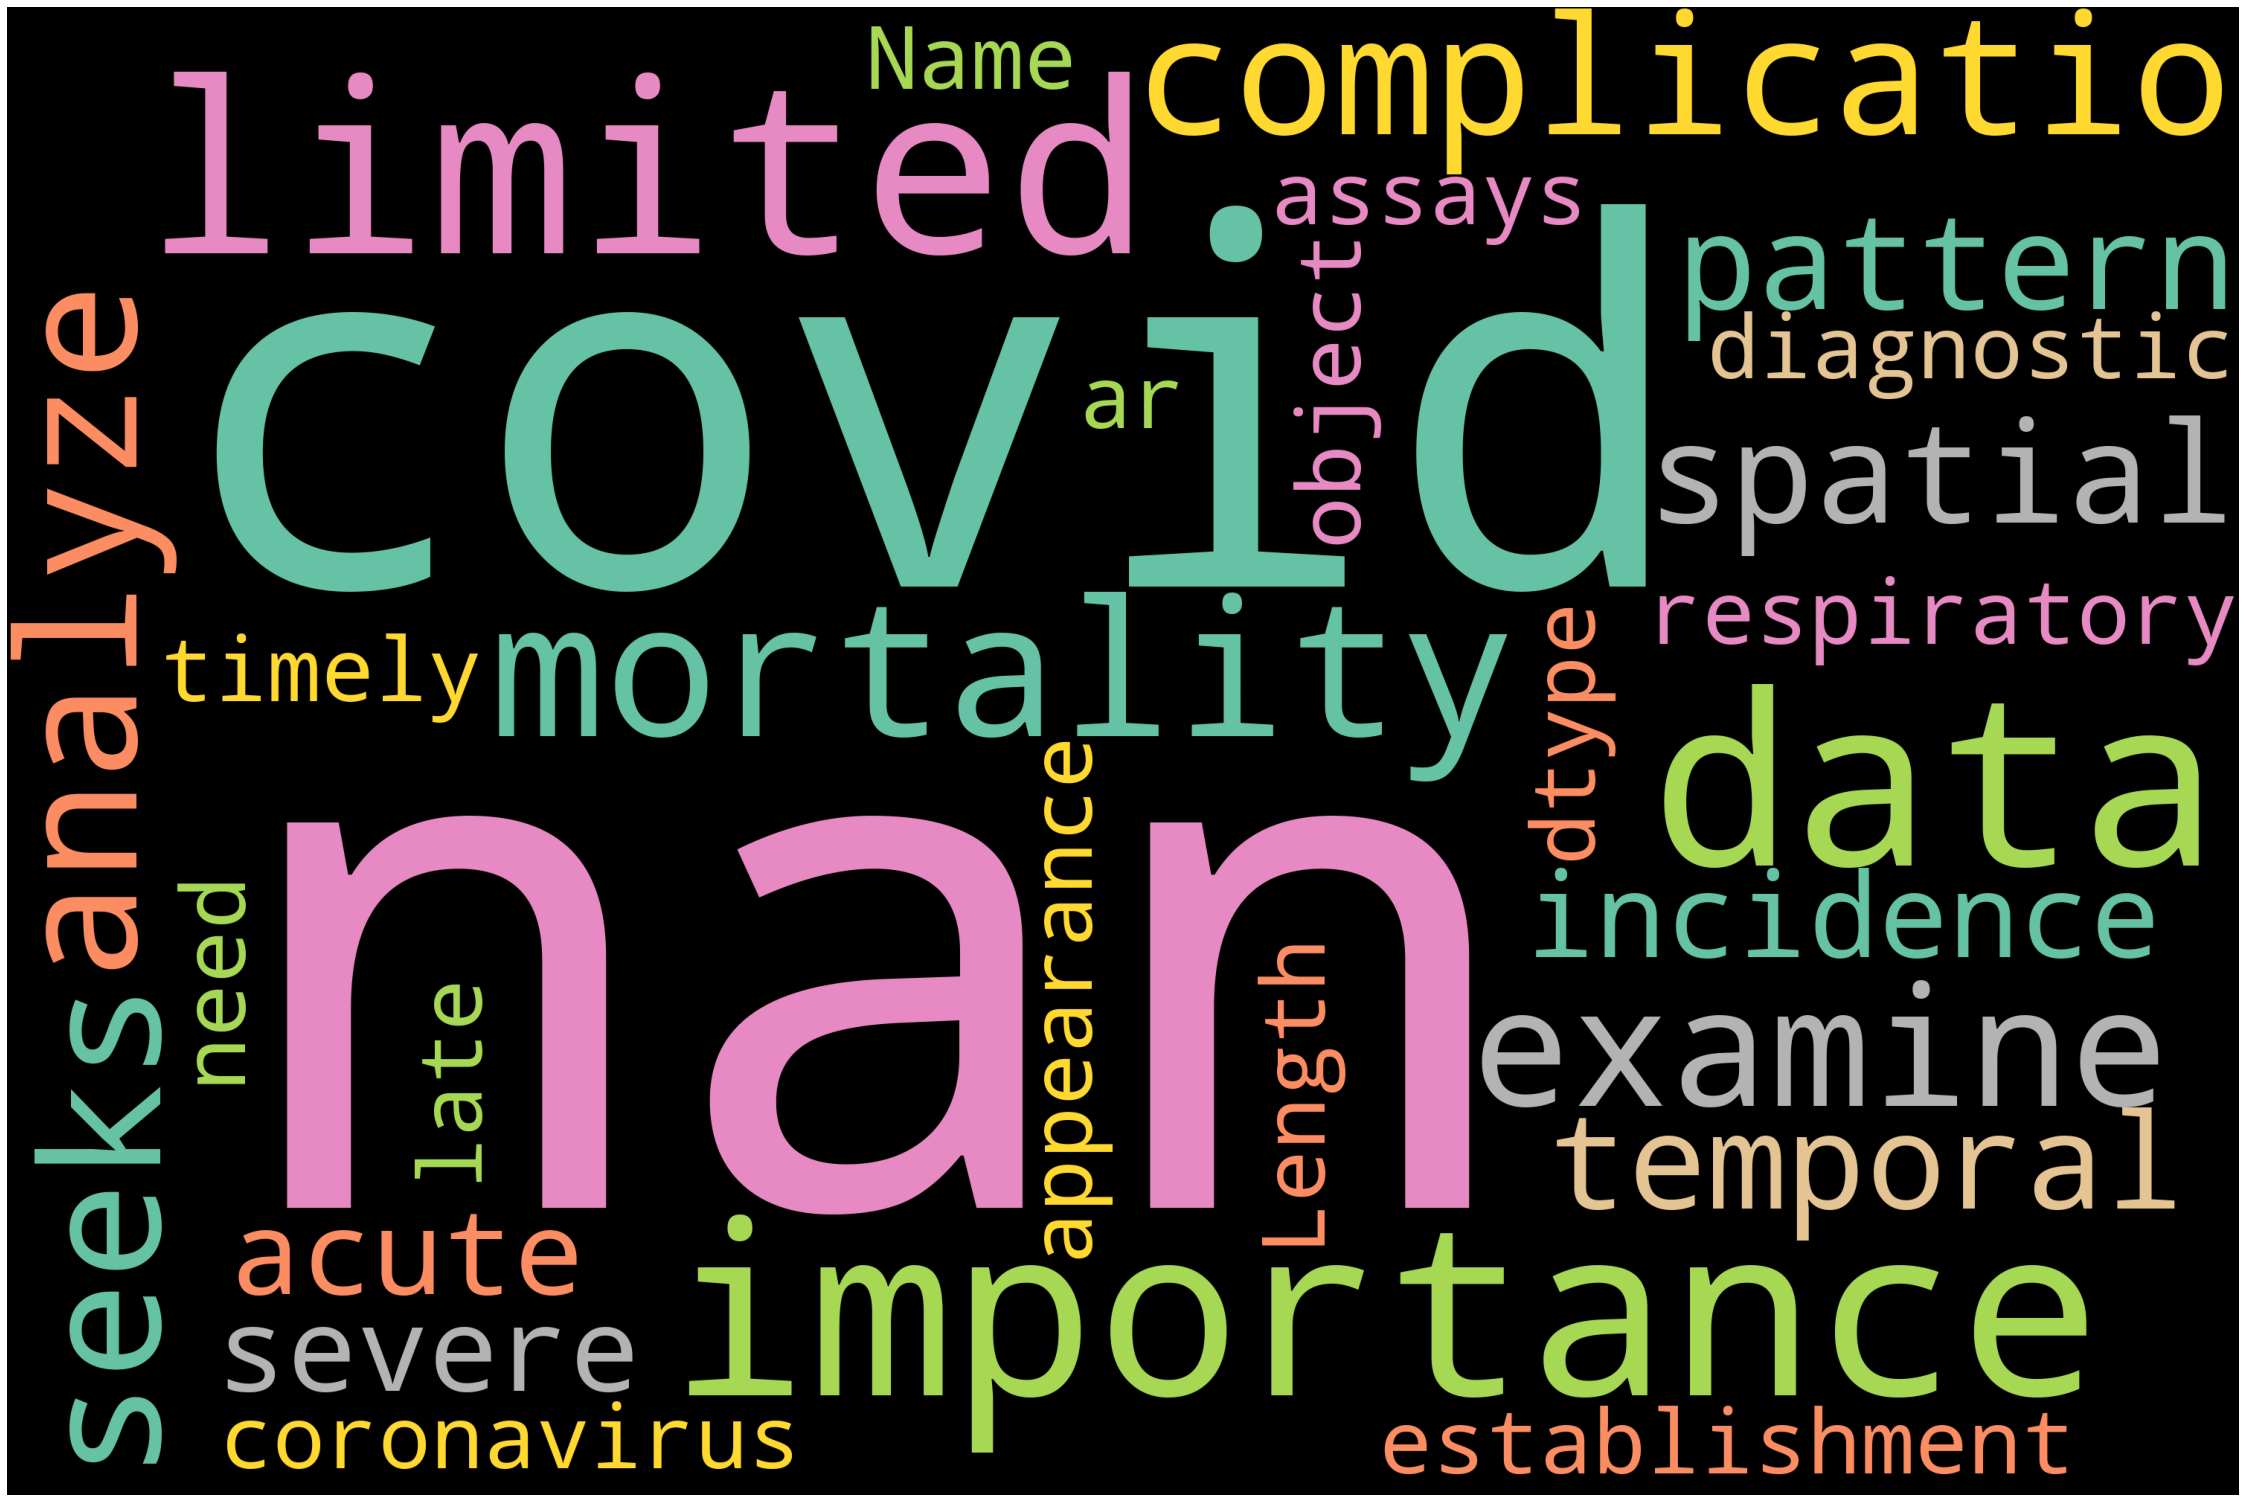

In [13]:
abstracts = str(metadata.abstract)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(abstracts)
# Plot
plot_cloud(wordcloud)

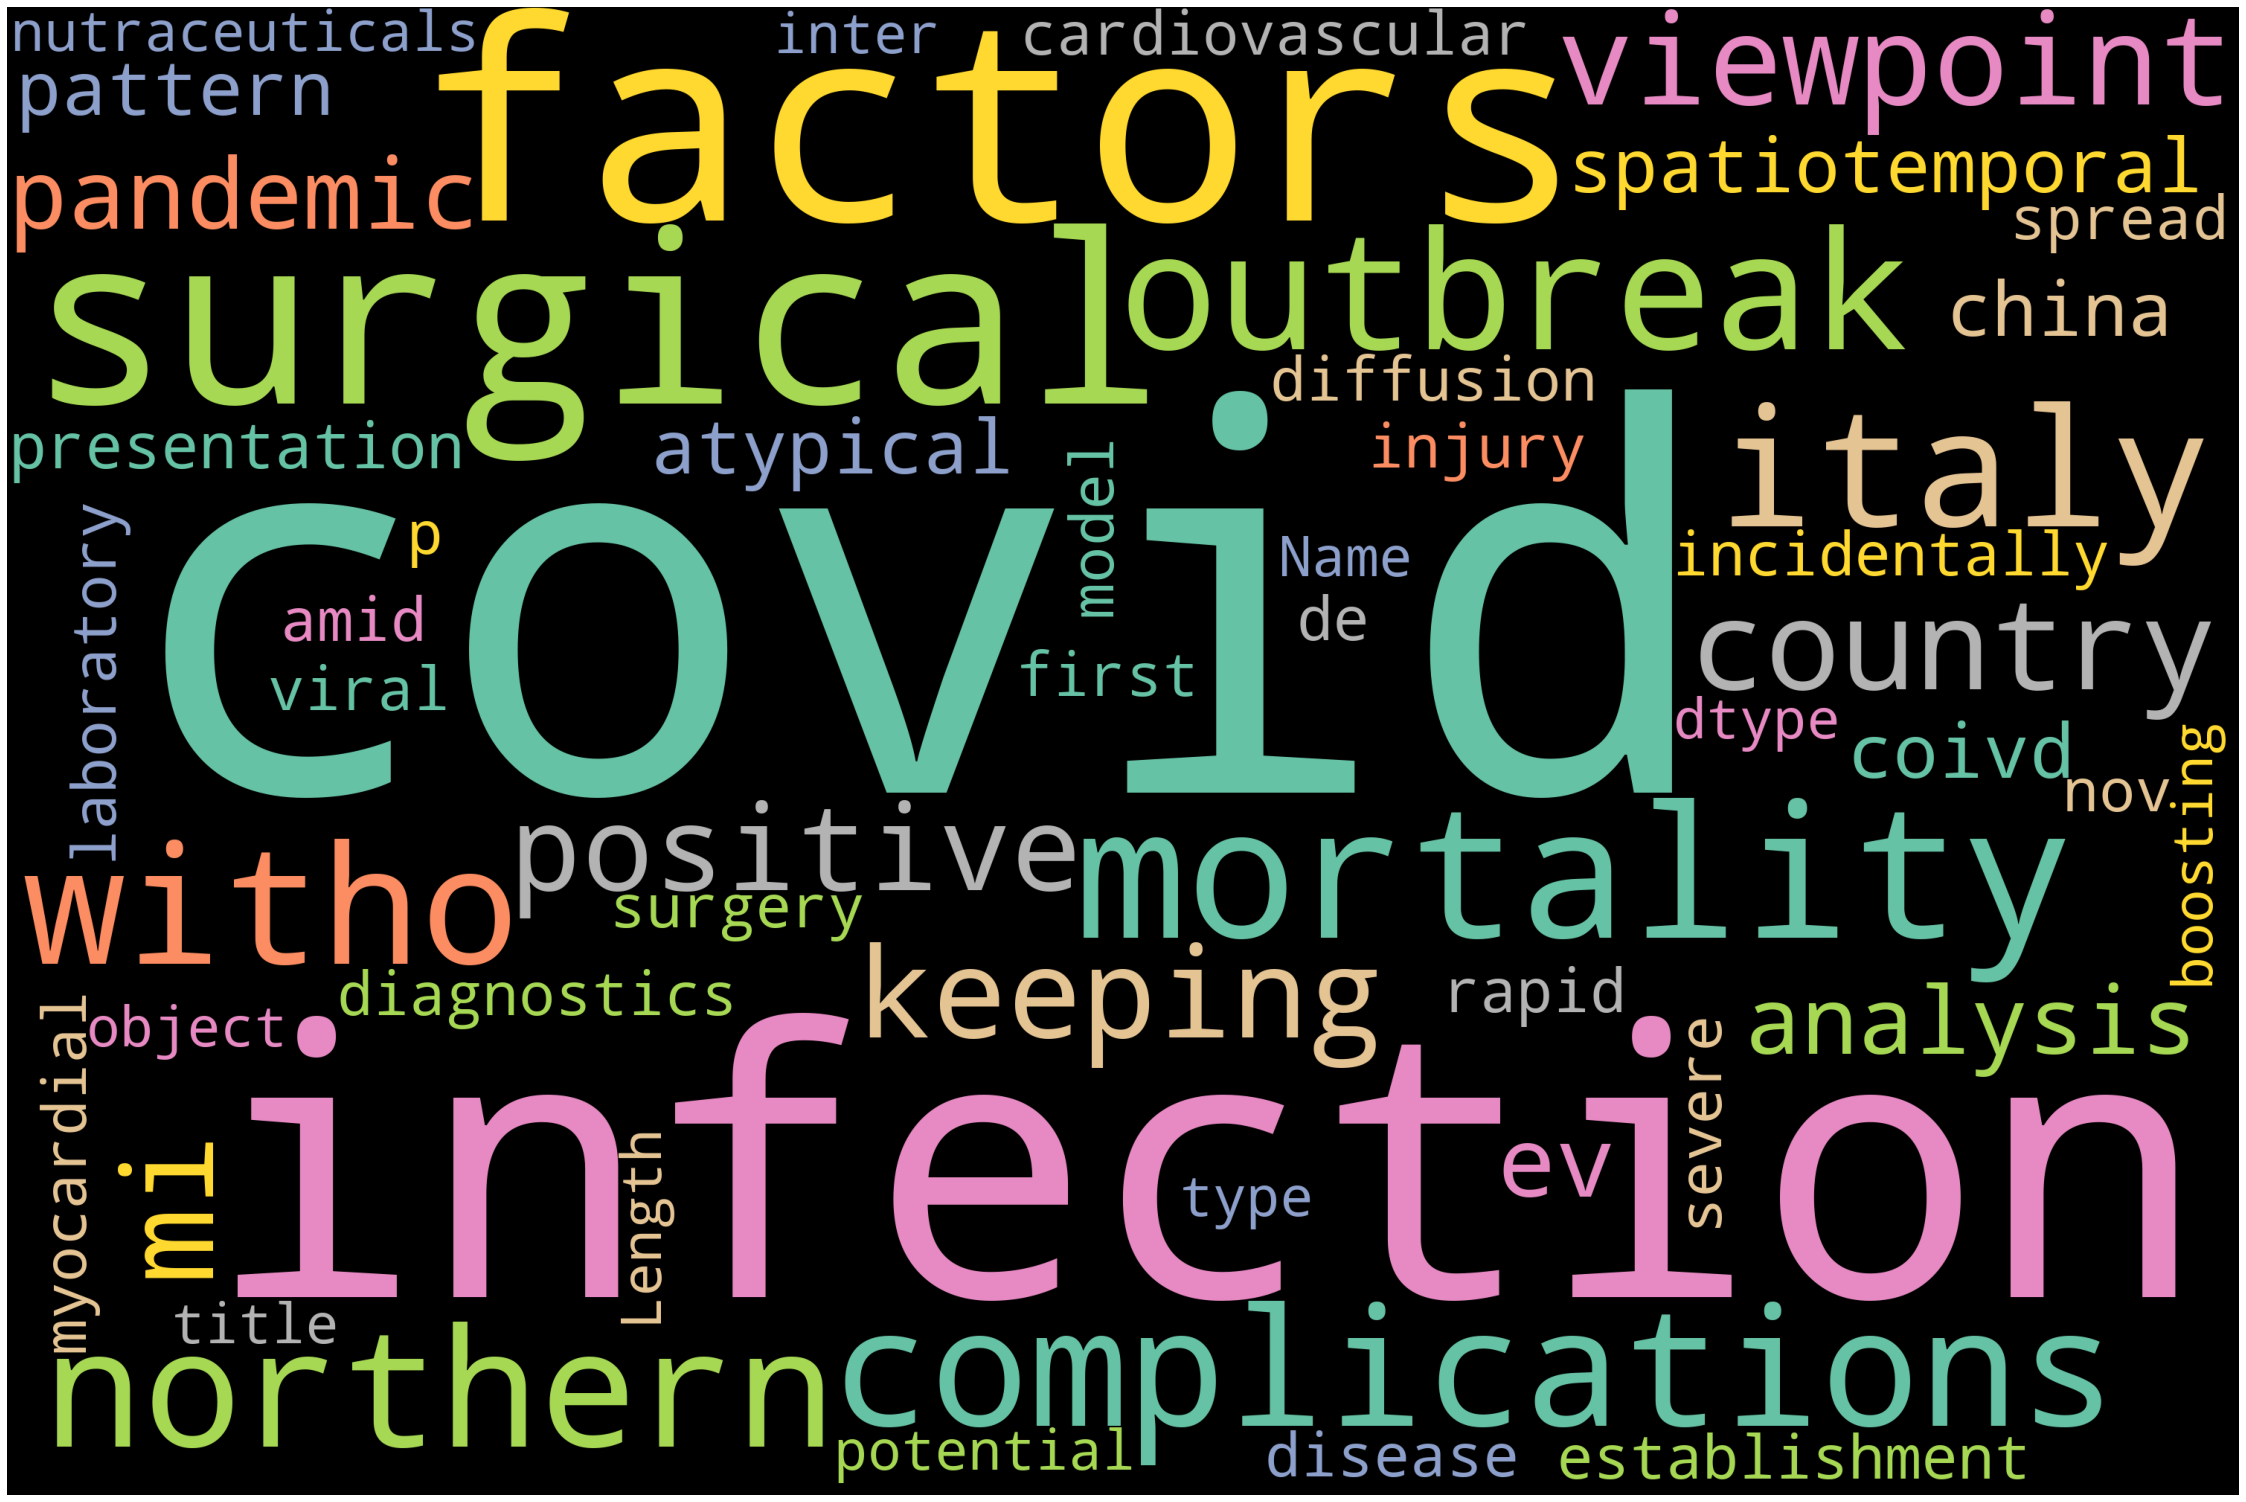

In [14]:
titles = str(metadata.title)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(titles)
# Plot
plot_cloud(wordcloud)

## Spacy work
Spacy is becomeing one of the go to libraries in NLP. The following exercise is intended as a basic start in using this library.

In [ ]:
!pip install scispacy
!python -m spacy download en_core_web_sm

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import scispacy
import spacy
import en_core_sci_lg
from scipy.spatial.distance import jensenshannon
import joblib
from joblib import dump, load
from IPython.display import HTML, display
from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output
from tqdm import tqdm
from os.path import isfile
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [5]:
# nlp = en_core_web_sm.load(disable=["tagger", "parser", "ner"])
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.max_length = 5000000

#### A sentence tokenizer

In [6]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [7]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym',
    r'\setlength{\oddsidemargin}{-69pt',  r'\usepackage{upgreek', r'\documentclass[12pt]{minimal'
]

In [8]:
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

#### Staring with the raw daframe in order to perform all basic steps using spacy.

In [22]:
all_abstracts = cord_metadata_raw.abstract
all_abstracts.dropna(inplace=True)

#### Transforming the data into a matrix of token counts    
Convert a collection of text documents to a matrix of token counts.    
Also saving the matrix.    
Refrence:    
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html



In [9]:
import os.path
from pathlib import Path
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
my_file = Path('data_vectorized.csv')
if my_file.is_file():
    data_vectorized=joblib.load('data_vectorized.csv','r')
else:
    data_vectorized = vectorizer.fit_transform(tqdm(all_abstracts))
    joblib.dump(vectorizer, 'vectorizer.csv')
    joblib.dump(data_vectorized, 'data_vectorized.csv')


In [10]:
data_vectorized.shape

(119002, 89603)

<AxesSubplot:ylabel='word'>

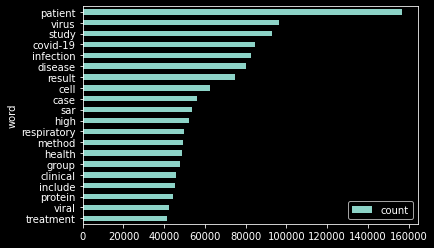

In [40]:
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

## TFIDF, Document Similarity, Doc2vec

In [43]:
#### Remove duplicates 
metadata.shape

(161564, 22)

In [49]:
#handling duplicate data (based on 'sha','title' and 'abstract')
print(f'metadatada frame before removing duplicates {metadata.shape}')
print(metadata[metadata.duplicated(subset=['sha','title','abstract'], keep=False) == True])
metadata.drop_duplicates(subset=['sha','title','abstract'],keep ='last',inplace=True)
print(f'Data Size after dropping duplicated data {metadata.shape}')

metadatada frame before removing duplicates (150888, 22)
Data Size after dropping duplicated data (142364, 22)


In [ ]:
#one more level of deduplication
print(f'metadatada frame before removing duplicates {metadata.shape}')
# print(metadata[metadata.duplicated(subset=['title','authors'], keep=False) == True])
metadata.drop_duplicates(subset=['title','authors'],keep ='last',inplace=True)
print(f'Data Size after dropping duplicated data {metadata.shape}')

In [79]:
from sklearn.decomposition import PCA
def pca_processing(n_components, data):
    pca = PCA(n_components=n_components).fit(data)
    data = pca.transform(data)
    return data

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_processing (data):
    tfidf = TfidfVectorizer( stop_words='english',use_idf=True)
    tfidf_matrix = tfidf.fit_transform(data)
    return tfidf_matrix

In [51]:
# a matrix with tfidf for the abstract
tfidf_matrix = tfidf_processing(metadata['abstract'])
tfidf_matrix

<142364x186336 sparse matrix of type '<class 'numpy.float64'>'
	with 9395541 stored elements in Compressed Sparse Row format>

#### Cosine similarity    
Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.    
Refrences:    
https://www.machinelearningplus.com/nlp/cosine-similarity/   
https://en.wikipedia.org/wiki/Cosine_similarity    
https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity    


In [58]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf_matrix[0:1], tfidf_matrix).flatten()

# 10 most related documents indices
related_docs_indices = cosine_similarities.argsort()[:-6:-1]
print("Related Document:",related_docs_indices)

# Cosine Similarties of related documents
print("Cosine Similarites of related documents",cosine_similarities[related_docs_indices])
related_docs_indices


Related Document: [142363  63942  64151  64145  64143]
Cosine Similarites of related documents [1. 1. 1. 1. 1.]


array([142363,  63942,  64151,  64145,  64143])

In [59]:
# print(metadata.iloc[142363])
# print(metadata.iloc[63942])


#### Obeservation    
I used the cosone similarity to identify dupliactes and rules to de duplicate based on sha, author title etc.    
Onece the metadata has been de duplicated the abstracts seem to be very dis similar ...

In [60]:
# abstract_1 = str(metadata.iloc[142363]['abstract'])

# # Import package
# from wordcloud import WordCloud
# # Generate word cloud
# wordcloud = WordCloud(width = 1000, height = 600, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(abstract_1)
# # Plot
# plot_cloud(wordcloud)

In [62]:
# metadata.iloc[63942]['abstract']
# abstract_2 = str(metadata.iloc[92129]['abstract'])

# # Import package
# from wordcloud import WordCloud
# # Generate word cloud
# wordcloud = WordCloud(width = 1000, height = 600, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(abstract_2)
# # Plot
# plot_cloud(wordcloud)

### Doc2Vec   
Doc2Vec is a Model that represents each Document as a Vector.   
Doc2vec uses an unsupervised learning approach to better understand documents as a whole.    

Refrences:    
https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-download-auto-examples-tutorials-run-doc2vec-lee-py   
https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137    

In [72]:
import gensim
from gensim.models import Doc2Vec

def doc2vec():
    document_tagged = []
    tagged_count = 0
    for _ in metadata['abstract'].values:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(_,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs, d2v

In [73]:
# Let's explore the data representation of doc2vec for abstract column.
# Visualization the doc2vec representation
%time doc2vec, dv2 = doc2vec()

CPU times: user 9min 46s, sys: 32.6 s, total: 10min 19s
Wall time: 5min 36s


In [69]:
# import seaborn as sns
# plt.figure(figsize=(16,16))
# sns.heatmap(doc2vec,cmap="coolwarm")
# doc2vec

array([[-0.01014166,  0.00782332, -0.03016238, ...,  0.00599989,
         0.01412055,  0.00125657],
       [-0.21295327, -0.03177911,  0.00285193, ..., -0.07412886,
         0.13799515,  0.05446359],
       [-0.02532511,  0.03865083, -0.17274423, ...,  0.12591946,
        -0.07505455, -0.08877271],
       ...,
       [-0.045819  ,  0.01455637, -0.01579119, ...,  0.01579092,
         0.02048116,  0.01884421],
       [-0.30220914,  0.09863379, -0.11500406, ..., -0.10557698,
         0.04152958,  0.19109643],
       [-0.03084014,  0.00309883, -0.02823484, ...,  0.02279992,
         0.01956115, -0.00268072]], dtype=float32)

Now, we can use the trained model to infer a vector for any piece of text by passing a list of words to the model.infer_vector function. This vector can then be compared with other vectors via cosine similarity.

In [74]:
vector = dv2.infer_vector(['factors', 'covid', 'infection'])
print(vector)

[-4.1136979e-03  2.1678326e-03 -4.0475708e-03  6.4265146e-04
 -4.7500930e-03 -1.3708157e-03 -4.6833605e-03 -3.7055044e-03
 -4.9224836e-03  2.9577564e-03 -2.3864186e-03 -4.5779459e-03
  2.4513891e-03 -7.7591088e-05  3.7331027e-03 -1.0362515e-03
 -1.1283931e-04  3.3947451e-03  3.9936830e-03  7.5932650e-04
 -2.8986274e-03 -2.2760201e-03 -4.9035298e-03 -4.3729669e-03
  1.6905545e-04  1.5366160e-03 -8.6253381e-04  4.2390199e-03
 -3.4530510e-03  1.6712757e-03  4.0579671e-03 -3.7906070e-03
 -2.2194816e-03  2.3168060e-03  1.9430872e-03 -2.7417715e-04
 -1.6037219e-03  1.4639146e-03 -1.5102326e-03 -1.3647937e-03
  8.5914688e-04 -2.2542761e-03 -6.0257077e-04  4.0895734e-03
 -1.8694511e-03  2.6679051e-03  2.7406791e-03 -7.5117423e-05
 -2.9583331e-03  6.9739966e-04  4.2518429e-03 -4.5234183e-04
  1.0225719e-03 -2.3437936e-03 -1.2469567e-04 -3.6369823e-03
 -3.7559075e-04  9.2380191e-04 -1.5146268e-03 -3.2108030e-05
 -1.0306678e-03 -1.8523046e-03  1.6985434e-03  1.5609157e-03
 -2.1422385e-04  4.96434

### K-Means clustering    
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html   
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203    
https://www.kaggle.com/phyothuhtet/document-clustering-self-organizing-map-kmeans   

In [81]:
from sklearn.cluster import KMeans

def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

In [84]:
kmeans4 = KMeans(4)
%time km4 = kmeans4.fit_predict(doc2vec)

kmeans5 = KMeans(5)
%time km5 = kmeans5.fit_predict(doc2vec)

kmeans6 = KMeans(6)
%time km6 = kmeans6.fit_predict(doc2vec)

kmeans7 = KMeans(7)
%time km7 = kmeans7.fit_predict(doc2vec)

CPU times: user 40.5 s, sys: 2.26 s, total: 42.8 s
Wall time: 9.18 s
CPU times: user 41.4 s, sys: 2.52 s, total: 43.9 s
Wall time: 10.2 s
CPU times: user 1min 1s, sys: 2.37 s, total: 1min 3s
Wall time: 13.4 s
CPU times: user 41.9 s, sys: 2.01 s, total: 43.9 s
Wall time: 12.5 s


#### Within Cluster and Between Cluster Analysis    


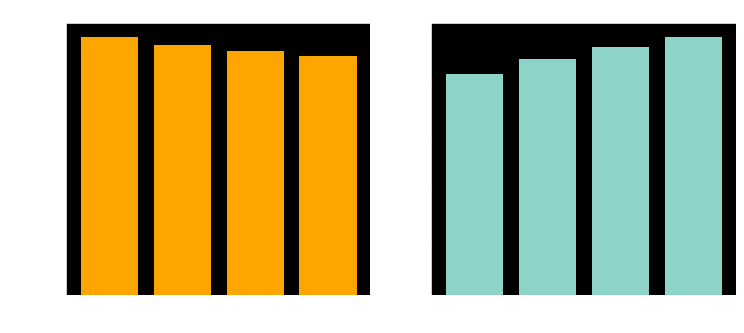

In [87]:
models = [kmeans4, kmeans5, kmeans6, kmeans7]
def plot_WCSS_BCSS(models, data):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in models]
    n_clusts = [4,5,6,7]
    
    ax[0].bar(n_clusts, wcss,color='orange', edgecolor='black', linewidth=1)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[0].set_title('Within Cluster Analysis')
    
    
    ## Plot BCSS 
    n_1 = (float(data.shape[0]) * float(data.shape[1])) - 1.0
    tss = n_1 * np.var(data)
    bcss = [tss - x for x in wcss]
    ax[1].bar(n_clusts, bcss,edgecolor='black')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    ax[1].set_title('Between Cluster Analysis')
    plt.show()
    

plot_WCSS_BCSS(models,doc2vec)

In [89]:
from sklearn.metrics import silhouette_score

def plot_silhouette(kms,data,nclusts):
    
    silhouette = []
    for i in kms:
        score = silhouette_score(data,i)
        print(score)
        silhouette.append(score)
    
    
    plt.bar(nclusts, silhouette,color = 'green')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

0.1452784
0.14644259
0.112297766
0.095109805


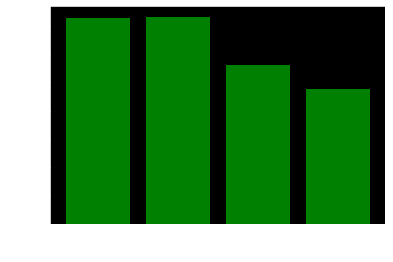

CPU times: user 3h 8min 44s, sys: 4min 5s, total: 3h 12min 50s
Wall time: 3h 14min 26s


In [91]:
%time plot_silhouette([km4,km5,km6,km7],doc2vec,[4,5,6,7])


In [ ]:
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++
# ++++++++++++++++++++++++